# Step 3 - Climate Analysis and Exploration

In [1]:
# import dependencies here

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sqlalchemy
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import datetime as dt

In [2]:
# create DB engine and connect to hawaii database
engine = create_engine("sqlite:///hawaii.sqlite")
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurements = Base.classes.measurements
Station = Base.classes.stations
session = Session(engine)

In [4]:
columns = inspector.get_columns("measurements")
for c in columns:
    print (c["name"], c["type"])

station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [5]:
columns = inspector.get_columns("stations")
for c in columns:
    print (c["name"], c["type"])

station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Precipitation Analysis:
- Design a query to retrieve the last 12 months of precipitation data.
- Select only the date and prcp values.
- Load the query results into a Pandas DataFrame and set the index to the date column.
- Plot the results using the DataFrame plot method.

In [6]:
# fetch date exactly before 12 months
date_delta = dt.date.today() - dt.timedelta(days = 365)
print (date_delta)

2017-04-24


In [7]:
prcp_data = session.query(Measurements.date, func.sum(Measurements.prcp)).\
            filter(Measurements.date >= date_delta). group_by(Measurements.date).all()


prcp_dict = {'date': [], 'prcp': []}
for i in prcp_data:
    (date, prcp) = i
    prcp_dict['date'].append(date)
    prcp_dict['prcp'].append(prcp)
    
prcp_df = pd.DataFrame(prcp_dict)
prcp_df.head()

,date,prcp
0,2017-04-24,0.06
1,2017-04-25,0.00
2,2017-04-26,0.39
3,2017-04-27,0.42
4,2017-04-28,4.24


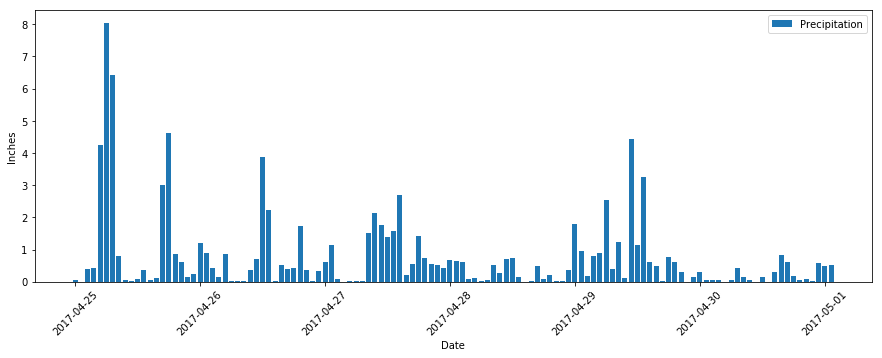

In [8]:
plt.figure(figsize = (15, 5))
ax = plt.subplot()
ax.bar(range(len(prcp_df["date"])), prcp_df["prcp"], label = "Precipitation")
ax.set_xticklabels(prcp_df["date"], rotation = 45)
ax.legend()
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()

# Station Analysis:

- Design a query to calculate the total number of stations.
- Design a query to find the most active stations.
- List the stations and observation counts in descending order
- Which station has the highest number of observations?
- Design a query to retrieve the last 12 months of temperature observation data (tobs).
- Filter by the station with the highest number of observations.
- Plot the results as a histogram with bins=12.

In [9]:
station_locations = session.query(Measurements).group_by(Measurements.station).count()
station_id = session.query(Measurements).group_by(Measurements.station)
print("Total number of stations: {}".format(station_locations))

Total number of stations: 9


In [10]:
(busy_station, count) = session.query(Measurements.station, func.count(Measurements.prcp)).\
                        group_by(Measurements.station). \
                        order_by(func.count(Measurements.prcp).desc()).first()
        
busy_station

'USC00519281'

In [11]:
station_data = session.query(Measurements.date, func.avg(Measurements.tobs)).\
                filter(Measurements.date >= date_delta).filter(Measurements.station == busy_station).\
                group_by(Measurements.date).all()

station_dict = {'date': [], 'temperature': []}
for p in station_data:
    (date, temp) = p
    station_dict['date'].append(date)
    station_dict['temperature'].append(temp)
    
station_df = pd.DataFrame(station_dict)
station_df.head()

,date,temperature
0,2017-04-24,68.0
1,2017-04-25,72.0
2,2017-04-26,74.0
3,2017-04-27,70.0
4,2017-04-28,67.0


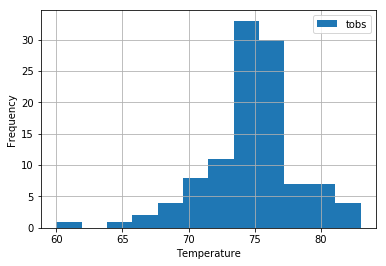

In [12]:
plt.hist(station_df["temperature"], bins = 12, label = "tobs")
plt.grid()
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Temperature Analysis:

- Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
- Plot the min, avg, and max temperature from your previous query as a bar chart.
- Use the average temperature as the bar height.
- Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [13]:
def calc_temps (start_date, end_date):
    
    sel = [func.min(Measurements.tobs),
           func.avg(Measurements.tobs),
           func.max(Measurements.tobs),
          ]
    
    temperature_values = session.query(*sel).filter((Measurements.date >= start_date) & (Measurements.date <= end_date)).all()
    return temperature_values

In [14]:
start_date = '2017-05-22'
end_date = '2017-06-05'
temperature_values = calc_temps(start_date, end_date)

min_temp = temperature_values[0][0]
avg_temp = round(temperature_values[0][1],1)
max_temp = temperature_values[0][2]

print(f"Minimum Temperature: {min_temp}" )
print(f"Average Temperature: {avg_temp}" )
print(f"Maximum Temperature: {max_temp}" )


Minimum Temperature: 69
Average Temperature: 76.4
Maximum Temperature: 87


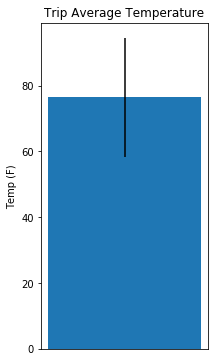

In [28]:
plt.figure(figsize=(3,6))
ax = plt.subplot()
ax.bar(range(1), avg_temp,width=0.25, yerr = [max_temp - min_temp])
ax.set_xticks([])
plt.title("Trip Average Temperature")
plt.ylabel("Temp (F)")
plt.show()